### 출처
https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/

In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import regularizers
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
import os
import sys
from six.moves import cPickle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 800:
        lr *= 0.5e-3
    elif epoch > 600:
        lr *= 1e-3
    elif epoch > 400:
        lr *= 1e-2
    elif epoch > 200:
        lr *- 1e-1
    return lr

In [3]:
def load_data():
    # Modify path string. use your path which your dataset is in
    path =  r'C:\Users\strea\Links\baseline_code_final (2)'
    fpath = os.path.join(path, 'train_data')
    
    with open(fpath, 'rb') as f:
        d = cPickle.load(f, encoding='bytes')
    X_train = d['data']
    y_train = d['labels']
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32) # 3072개 숫자가 한줄로 이어진 배열 하나를 32x32짜리 배열 3개로 만듦
    X_train = X_train.transpose(0, 2, 3, 1)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

x_train, y_train = load_data()

In [4]:
# seed 값 설정
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train[0][0][0:5]

array([[131., 136., 169.],
       [144., 150., 183.],
       [141., 148., 182.],
       [143., 150., 184.],
       [146., 156., 187.]], dtype=float32)

In [6]:
# z-score : 표준편차를 단위로서 보았을 때 측정치가 평균에서 얼마만큼 일탈하였는가를 보는 것이다. 
#           개인의 측정치 X와 평균치 M과의 차를 표준편차(SD)로 나눈 수이다.
mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7) # 각 원소와 평균과의 차이를 표준편차로 나눔(ppt에 나옴 -> normalized data)
x_test = (x_test-mean)/(std+1e-7)
print(mean, std, x_train.shape, x_test.shape)
x_train[0][0][0:5]

120.98071 64.11213 (28000, 32, 32, 3) (12000, 32, 32, 3)


array([[0.15627757, 0.23426592, 0.7489891 ],
       [0.3590473 , 0.45263335, 0.96735656],
       [0.31225428, 0.421438  , 0.95175886],
       [0.34344962, 0.45263335, 0.9829542 ],
       [0.39024264, 0.54621935, 1.0297472 ]], dtype=float32)

In [7]:
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [8]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:])) 
# 32x32에 3x3짜리 필터로 padding은 사이즈 유지할 만큼 주고 / l2 regularization을 수행한다(오버피팅 방지), 그리고 input shape을 지정해준다
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2

In [9]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [10]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.h5'

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=modelpath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [11]:
# training
batch_size = 32
# opt_rms = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=lr_schedule(0)),
             metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=1000,
                    verbose=1,validation_data=(x_test,y_test),callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
875/875 [==============================] - 23s 26ms/step - loss: 2.0964 - acc: 0.3689 - val_loss: 1.5152 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 1.51519, saving model to ./model/01-1.5152.h5
Epoch 2/1000
875/875 [==============================] - 19s 22ms/step - loss: 1.4889 - acc: 0.5101 - val_loss: 1.3253 - val_acc: 0.5944

Epoch 00002: val_loss improved from 1.51519 to 1.32530, saving model to ./model/02-1.3253.h5
Epoch 3/1000
875/875 [==============================] - 19s 22ms/step - loss: 1.2377 - acc: 0.5919 - val_loss: 1.3615 - val_acc: 0.5906

Epoch 00003: val_loss did not improve from 1.32530
Epoch 4/1000
875/875 [==============================] - 19s 22ms/step - loss: 1.0897 - acc: 0.6388 - val_loss: 1.2625 - val_acc: 0.6378

Epoch 00004: val_loss improved from 1.32530 to 1.26252, saving model to ./model/04-1.2625.h5
Epoch 5/1000
875/875 [==============================] - 19s 22ms/step - loss: 

875/875 [==============================] - 19s 22ms/step - loss: 0.7015 - acc: 0.8256 - val_loss: 0.6876 - val_acc: 0.8393

Epoch 00040: val_loss did not improve from 0.66815
Epoch 41/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.7093 - acc: 0.8221 - val_loss: 0.7009 - val_acc: 0.8330

Epoch 00041: val_loss did not improve from 0.66815
Epoch 42/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.7011 - acc: 0.8264 - val_loss: 0.7397 - val_acc: 0.8203

Epoch 00042: val_loss did not improve from 0.66815
Epoch 43/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6998 - acc: 0.8259 - val_loss: 0.7274 - val_acc: 0.8286

Epoch 00043: val_loss did not improve from 0.66815
Epoch 44/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6992 - acc: 0.8266 - val_loss: 0.7094 - val_acc: 0.8389

Epoch 00044: val_loss did not improve from 0.66815
Epoch 45/1000
875/875 [==============================] - 19s 22ms/ste

875/875 [==============================] - 19s 22ms/step - loss: 0.6625 - acc: 0.8452 - val_loss: 0.6974 - val_acc: 0.8438

Epoch 00083: val_loss did not improve from 0.64203
Epoch 84/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6677 - acc: 0.8423 - val_loss: 0.6638 - val_acc: 0.8552

Epoch 00084: val_loss did not improve from 0.64203
Epoch 85/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6681 - acc: 0.8407 - val_loss: 0.6726 - val_acc: 0.8522

Epoch 00085: val_loss did not improve from 0.64203
Epoch 86/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6662 - acc: 0.8413 - val_loss: 0.6494 - val_acc: 0.8578

Epoch 00086: val_loss did not improve from 0.64203
Epoch 87/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6666 - acc: 0.8420 - val_loss: 0.6367 - val_acc: 0.8612

Epoch 00087: val_loss improved from 0.64203 to 0.63671, saving model to ./model/87-0.6367.h5
Epoch 88/1000
875/875 [====

875/875 [==============================] - 19s 22ms/step - loss: 0.6514 - acc: 0.8500 - val_loss: 0.6707 - val_acc: 0.8508

Epoch 00126: val_loss did not improve from 0.63671
Epoch 127/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6535 - acc: 0.8473 - val_loss: 0.6544 - val_acc: 0.8549

Epoch 00127: val_loss did not improve from 0.63671
Epoch 128/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6539 - acc: 0.8470 - val_loss: 0.6931 - val_acc: 0.8470

Epoch 00128: val_loss did not improve from 0.63671
Epoch 129/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6535 - acc: 0.8473 - val_loss: 0.6727 - val_acc: 0.8534

Epoch 00129: val_loss did not improve from 0.63671
Epoch 130/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6500 - acc: 0.8507 - val_loss: 0.6311 - val_acc: 0.8644

Epoch 00130: val_loss improved from 0.63671 to 0.63112, saving model to ./model/130-0.6311.h5
Epoch 131/1000
875/875

875/875 [==============================] - 19s 22ms/step - loss: 0.6391 - acc: 0.8530 - val_loss: 0.6765 - val_acc: 0.8522

Epoch 00169: val_loss did not improve from 0.62186
Epoch 170/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6443 - acc: 0.8531 - val_loss: 0.6535 - val_acc: 0.8575

Epoch 00170: val_loss did not improve from 0.62186
Epoch 171/1000
875/875 [==============================] - 19s 21ms/step - loss: 0.6467 - acc: 0.8529 - val_loss: 0.6651 - val_acc: 0.8572

Epoch 00171: val_loss did not improve from 0.62186
Epoch 172/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6447 - acc: 0.8550 - val_loss: 0.6852 - val_acc: 0.8467

Epoch 00172: val_loss did not improve from 0.62186
Epoch 173/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6419 - acc: 0.8515 - val_loss: 0.6915 - val_acc: 0.8427

Epoch 00173: val_loss did not improve from 0.62186
Epoch 174/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.6375 - acc: 0.8559 - val_loss: 0.7172 - val_acc: 0.8452

Epoch 00212: val_loss did not improve from 0.60249
Epoch 213/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6356 - acc: 0.8552 - val_loss: 0.6625 - val_acc: 0.8571

Epoch 00213: val_loss did not improve from 0.60249
Epoch 214/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6385 - acc: 0.8546 - val_loss: 0.7214 - val_acc: 0.8393

Epoch 00214: val_loss did not improve from 0.60249
Epoch 215/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6343 - acc: 0.8556 - val_loss: 0.6477 - val_acc: 0.8618

Epoch 00215: val_loss did not improve from 0.60249
Epoch 216/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6411 - acc: 0.8531 - val_loss: 0.7478 - val_acc: 0.8379

Epoch 00216: val_loss did not improve from 0.60249
Epoch 217/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.6343 - acc: 0.8556 - val_loss: 0.6529 - val_acc: 0.8558

Epoch 00255: val_loss did not improve from 0.60249
Epoch 256/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6300 - acc: 0.8580 - val_loss: 0.6610 - val_acc: 0.8582

Epoch 00256: val_loss did not improve from 0.60249
Epoch 257/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6349 - acc: 0.8575 - val_loss: 0.6507 - val_acc: 0.8619

Epoch 00257: val_loss did not improve from 0.60249
Epoch 258/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6323 - acc: 0.8588 - val_loss: 0.6631 - val_acc: 0.8596 1s - lo

Epoch 00258: val_loss did not improve from 0.60249
Epoch 259/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6353 - acc: 0.8592 - val_loss: 0.6499 - val_acc: 0.8616

Epoch 00259: val_loss did not improve from 0.60249
Epoch 260/1000
875/875 [==============================] -

875/875 [==============================] - 19s 22ms/step - loss: 0.6273 - acc: 0.8612 - val_loss: 0.6432 - val_acc: 0.8624 - loss: 0.627

Epoch 00298: val_loss did not improve from 0.60249
Epoch 299/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6328 - acc: 0.8599 - val_loss: 0.6515 - val_acc: 0.8606

Epoch 00299: val_loss did not improve from 0.60249
Epoch 300/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6281 - acc: 0.8606 - val_loss: 0.6700 - val_acc: 0.8574

Epoch 00300: val_loss did not improve from 0.60249
Epoch 301/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6308 - acc: 0.8584 - val_loss: 0.6931 - val_acc: 0.8433

Epoch 00301: val_loss did not improve from 0.60249
Epoch 302/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6283 - acc: 0.8599 - val_loss: 0.7641 - val_acc: 0.8304

Epoch 00302: val_loss did not improve from 0.60249
Epoch 303/1000
875/875 [===========================

875/875 [==============================] - 19s 22ms/step - loss: 0.6276 - acc: 0.8584 - val_loss: 0.6562 - val_acc: 0.8600

Epoch 00341: val_loss did not improve from 0.60249
Epoch 342/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6279 - acc: 0.8594 - val_loss: 0.6480 - val_acc: 0.8617

Epoch 00342: val_loss did not improve from 0.60249
Epoch 343/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6198 - acc: 0.8622 - val_loss: 0.6396 - val_acc: 0.8607

Epoch 00343: val_loss did not improve from 0.60249
Epoch 344/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6244 - acc: 0.8611 - val_loss: 0.6178 - val_acc: 0.8687

Epoch 00344: val_loss did not improve from 0.60249
Epoch 345/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6210 - acc: 0.8609 - val_loss: 0.6601 - val_acc: 0.8566

Epoch 00345: val_loss did not improve from 0.60249
Epoch 346/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.6297 - acc: 0.8601 - val_loss: 0.6880 - val_acc: 0.8534

Epoch 00384: val_loss did not improve from 0.60249
Epoch 385/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6205 - acc: 0.8609 - val_loss: 0.6616 - val_acc: 0.8593

Epoch 00385: val_loss did not improve from 0.60249
Epoch 386/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6243 - acc: 0.8611 - val_loss: 0.6824 - val_acc: 0.8562

Epoch 00386: val_loss did not improve from 0.60249
Epoch 387/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6255 - acc: 0.8599 - val_loss: 0.6635 - val_acc: 0.8574

Epoch 00387: val_loss did not improve from 0.60249
Epoch 388/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.6197 - acc: 0.8627 - val_loss: 0.6662 - val_acc: 0.8608

Epoch 00388: val_loss did not improve from 0.60249
Epoch 389/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.5146 - acc: 0.8967 - val_loss: 0.6062 - val_acc: 0.8795

Epoch 00427: val_loss did not improve from 0.60249
Epoch 428/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.5106 - acc: 0.8985 - val_loss: 0.6027 - val_acc: 0.8796

Epoch 00428: val_loss did not improve from 0.60249
Epoch 429/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.5124 - acc: 0.8968 - val_loss: 0.6081 - val_acc: 0.8783

Epoch 00429: val_loss did not improve from 0.60249
Epoch 430/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.5103 - acc: 0.8968 - val_loss: 0.6038 - val_acc: 0.8792

Epoch 00430: val_loss did not improve from 0.60249
Epoch 431/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.5064 - acc: 0.8998 - val_loss: 0.6018 - val_acc: 0.8804

Epoch 00431: val_loss improved from 0.60249 to 0.60182, saving model to ./model/431-0.6018.h5
Epoch 432/1000
875/875


Epoch 00467: val_loss improved from 0.58361 to 0.58265, saving model to ./model/467-0.5826.h5
Epoch 468/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4780 - acc: 0.9039 - val_loss: 0.5830 - val_acc: 0.8852

Epoch 00468: val_loss did not improve from 0.58265
Epoch 469/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4794 - acc: 0.9044 - val_loss: 0.5830 - val_acc: 0.8848

Epoch 00469: val_loss did not improve from 0.58265
Epoch 470/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4758 - acc: 0.9075 - val_loss: 0.5852 - val_acc: 0.8843

Epoch 00470: val_loss did not improve from 0.58265
Epoch 471/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4803 - acc: 0.9048 - val_loss: 0.5800 - val_acc: 0.8855

Epoch 00471: val_loss improved from 0.58265 to 0.58000, saving model to ./model/471-0.5800.h5
Epoch 472/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4747 - acc: 0.9071 -

875/875 [==============================] - 19s 22ms/step - loss: 0.4571 - acc: 0.9068 - val_loss: 0.5725 - val_acc: 0.8868

Epoch 00509: val_loss did not improve from 0.57115
Epoch 510/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4561 - acc: 0.9104 - val_loss: 0.5732 - val_acc: 0.8865

Epoch 00510: val_loss did not improve from 0.57115
Epoch 511/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4533 - acc: 0.9103 - val_loss: 0.5722 - val_acc: 0.8866

Epoch 00511: val_loss did not improve from 0.57115
Epoch 512/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4549 - acc: 0.9103 - val_loss: 0.5725 - val_acc: 0.8866

Epoch 00512: val_loss did not improve from 0.57115
Epoch 513/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4505 - acc: 0.9115 - val_loss: 0.5712 - val_acc: 0.8865

Epoch 00513: val_loss did not improve from 0.57115
Epoch 514/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.4350 - acc: 0.9132 - val_loss: 0.5643 - val_acc: 0.8871

Epoch 00550: val_loss did not improve from 0.56282
Epoch 551/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4419 - acc: 0.9135 - val_loss: 0.5615 - val_acc: 0.8874

Epoch 00551: val_loss improved from 0.56282 to 0.56154, saving model to ./model/551-0.5615.h5
Epoch 552/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4410 - acc: 0.9140 - val_loss: 0.5657 - val_acc: 0.8865

Epoch 00552: val_loss did not improve from 0.56154
Epoch 553/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4424 - acc: 0.9110 - val_loss: 0.5657 - val_acc: 0.8865

Epoch 00553: val_loss did not improve from 0.56154
Epoch 554/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4378 - acc: 0.9117 - val_loss: 0.5645 - val_acc: 0.8867

Epoch 00554: val_loss did not improve from 0.56154
Epoch 555/1000
875/875

875/875 [==============================] - 19s 22ms/step - loss: 0.4266 - acc: 0.9141 - val_loss: 0.5546 - val_acc: 0.8883

Epoch 00591: val_loss did not improve from 0.55273
Epoch 592/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4245 - acc: 0.9157 - val_loss: 0.5544 - val_acc: 0.8882

Epoch 00592: val_loss did not improve from 0.55273
Epoch 593/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4203 - acc: 0.9155 - val_loss: 0.5529 - val_acc: 0.8892

Epoch 00593: val_loss did not improve from 0.55273
Epoch 594/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4240 - acc: 0.9150 - val_loss: 0.5536 - val_acc: 0.8886

Epoch 00594: val_loss did not improve from 0.55273
Epoch 595/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4279 - acc: 0.9154 - val_loss: 0.5573 - val_acc: 0.8883

Epoch 00595: val_loss did not improve from 0.55273
Epoch 596/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.4133 - acc: 0.9185 - val_loss: 0.5526 - val_acc: 0.8890

Epoch 00633: val_loss did not improve from 0.54989
Epoch 634/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4177 - acc: 0.9186 - val_loss: 0.5532 - val_acc: 0.8889

Epoch 00634: val_loss did not improve from 0.54989
Epoch 635/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4200 - acc: 0.9164 - val_loss: 0.5554 - val_acc: 0.8878

Epoch 00635: val_loss did not improve from 0.54989
Epoch 636/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4146 - acc: 0.9195 - val_loss: 0.5533 - val_acc: 0.8884

Epoch 00636: val_loss did not improve from 0.54989
Epoch 637/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4143 - acc: 0.9177 - val_loss: 0.5516 - val_acc: 0.8892

Epoch 00637: val_loss did not improve from 0.54989
Epoch 638/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.4156 - acc: 0.9170 - val_loss: 0.5528 - val_acc: 0.8882

Epoch 00676: val_loss did not improve from 0.54956
Epoch 677/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4177 - acc: 0.9173 - val_loss: 0.5516 - val_acc: 0.8885

Epoch 00677: val_loss did not improve from 0.54956
Epoch 678/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4146 - acc: 0.9186 - val_loss: 0.5553 - val_acc: 0.8882

Epoch 00678: val_loss did not improve from 0.54956
Epoch 679/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4154 - acc: 0.9171 - val_loss: 0.5540 - val_acc: 0.8884

Epoch 00679: val_loss did not improve from 0.54956
Epoch 680/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4153 - acc: 0.9177 - val_loss: 0.5539 - val_acc: 0.8887

Epoch 00680: val_loss did not improve from 0.54956
Epoch 681/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.4166 - acc: 0.9163 - val_loss: 0.5541 - val_acc: 0.8885

Epoch 00719: val_loss did not improve from 0.54956
Epoch 720/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4161 - acc: 0.9170 - val_loss: 0.5545 - val_acc: 0.8886

Epoch 00720: val_loss did not improve from 0.54956
Epoch 721/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4111 - acc: 0.9181 - val_loss: 0.5522 - val_acc: 0.8888

Epoch 00721: val_loss did not improve from 0.54956
Epoch 722/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4074 - acc: 0.9200 - val_loss: 0.5516 - val_acc: 0.8886

Epoch 00722: val_loss did not improve from 0.54956
Epoch 723/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4178 - acc: 0.9167 - val_loss: 0.5537 - val_acc: 0.8884

Epoch 00723: val_loss did not improve from 0.54956
Epoch 724/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.4128 - acc: 0.9186 - val_loss: 0.5520 - val_acc: 0.8880

Epoch 00762: val_loss did not improve from 0.54903
Epoch 763/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4120 - acc: 0.9196 - val_loss: 0.5526 - val_acc: 0.8876

Epoch 00763: val_loss did not improve from 0.54903
Epoch 764/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4122 - acc: 0.9187 - val_loss: 0.5526 - val_acc: 0.8882

Epoch 00764: val_loss did not improve from 0.54903
Epoch 765/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4177 - acc: 0.9173 - val_loss: 0.5551 - val_acc: 0.8877

Epoch 00765: val_loss did not improve from 0.54903
Epoch 766/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4113 - acc: 0.9203 - val_loss: 0.5527 - val_acc: 0.8884

Epoch 00766: val_loss did not improve from 0.54903
Epoch 767/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.4112 - acc: 0.9185 - val_loss: 0.5500 - val_acc: 0.8892

Epoch 00805: val_loss did not improve from 0.54903
Epoch 806/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4152 - acc: 0.9162 - val_loss: 0.5504 - val_acc: 0.8891

Epoch 00806: val_loss did not improve from 0.54903
Epoch 807/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4111 - acc: 0.9171 - val_loss: 0.5496 - val_acc: 0.8894

Epoch 00807: val_loss did not improve from 0.54903
Epoch 808/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4112 - acc: 0.9175 - val_loss: 0.5482 - val_acc: 0.8892

Epoch 00808: val_loss improved from 0.54903 to 0.54816, saving model to ./model/808-0.5482.h5
Epoch 809/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4065 - acc: 0.9190 - val_loss: 0.5519 - val_acc: 0.8882

Epoch 00809: val_loss did not improve from 0.54816
Epoch 810/1000
875/875

875/875 [==============================] - 19s 22ms/step - loss: 0.4081 - acc: 0.9182 - val_loss: 0.5513 - val_acc: 0.8898

Epoch 00848: val_loss did not improve from 0.54816
Epoch 849/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4137 - acc: 0.9181 - val_loss: 0.5512 - val_acc: 0.8886

Epoch 00849: val_loss did not improve from 0.54816
Epoch 850/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4140 - acc: 0.9184 - val_loss: 0.5530 - val_acc: 0.8885

Epoch 00850: val_loss did not improve from 0.54816
Epoch 851/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4083 - acc: 0.9180 - val_loss: 0.5535 - val_acc: 0.8882

Epoch 00851: val_loss did not improve from 0.54816
Epoch 852/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4085 - acc: 0.9200 - val_loss: 0.5510 - val_acc: 0.8888

Epoch 00852: val_loss did not improve from 0.54816
Epoch 853/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.4130 - acc: 0.9177 - val_loss: 0.5517 - val_acc: 0.8891

Epoch 00891: val_loss did not improve from 0.54816
Epoch 892/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4084 - acc: 0.9189 - val_loss: 0.5529 - val_acc: 0.8888

Epoch 00892: val_loss did not improve from 0.54816
Epoch 893/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4103 - acc: 0.9178 - val_loss: 0.5536 - val_acc: 0.8888

Epoch 00893: val_loss did not improve from 0.54816
Epoch 894/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4050 - acc: 0.9187 - val_loss: 0.5538 - val_acc: 0.8887

Epoch 00894: val_loss did not improve from 0.54816
Epoch 895/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4129 - acc: 0.9173 - val_loss: 0.5534 - val_acc: 0.8878

Epoch 00895: val_loss did not improve from 0.54816
Epoch 896/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.4149 - acc: 0.9169 - val_loss: 0.5500 - val_acc: 0.8895

Epoch 00934: val_loss did not improve from 0.54816
Epoch 935/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4105 - acc: 0.9199 - val_loss: 0.5500 - val_acc: 0.8886

Epoch 00935: val_loss did not improve from 0.54816
Epoch 936/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4069 - acc: 0.9201 - val_loss: 0.5511 - val_acc: 0.8892

Epoch 00936: val_loss did not improve from 0.54816
Epoch 937/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4046 - acc: 0.9204 - val_loss: 0.5501 - val_acc: 0.8885

Epoch 00937: val_loss did not improve from 0.54816
Epoch 938/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4041 - acc: 0.9211 - val_loss: 0.5521 - val_acc: 0.8890

Epoch 00938: val_loss did not improve from 0.54816
Epoch 939/1000
875/875 [==============================] - 19s 22m

875/875 [==============================] - 19s 22ms/step - loss: 0.4035 - acc: 0.9216 - val_loss: 0.5510 - val_acc: 0.8887

Epoch 00977: val_loss did not improve from 0.54816
Epoch 978/1000
875/875 [==============================] - 19s 21ms/step - loss: 0.4109 - acc: 0.9179 - val_loss: 0.5520 - val_acc: 0.8887

Epoch 00978: val_loss did not improve from 0.54816
Epoch 979/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4131 - acc: 0.9168 - val_loss: 0.5523 - val_acc: 0.8884

Epoch 00979: val_loss did not improve from 0.54816
Epoch 980/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4047 - acc: 0.9198 - val_loss: 0.5495 - val_acc: 0.8891

Epoch 00980: val_loss did not improve from 0.54816
Epoch 981/1000
875/875 [==============================] - 19s 22ms/step - loss: 0.4131 - acc: 0.9166 - val_loss: 0.5504 - val_acc: 0.8890

Epoch 00981: val_loss did not improve from 0.54816
Epoch 982/1000
875/875 [==============================] - 19s 22m

In [12]:
# # save to disk
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = '60165060_trained_model.h5'

# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

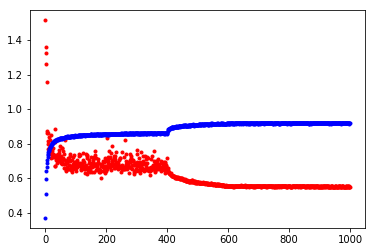

In [13]:
# y_loss에 학습셋으로 실험 결과의 오차 값을 저장
y_loss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_loss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()
# loss: 1.5541 - acc: 0.4574
# 그냥 baseline 그대로 돌리면 loss 1.4783 acc 0.5014
# loss: 0.4548 - acc: 0.8858 - val_loss: 0.4985 - val_acc: 0.8768 확실히 성능 개선됨

# lr 달리 줬더니 그림이 저렇게 나옴.....

In [14]:
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

12000/12000 [==============================] - 2s 131us/step

Test result: 88.833 loss: 0.550
